### Update: 2024-03-07
After considering correlation and conducting new filtering on the data, the prediction accuracy of the next day's bicycle rental data reached around 3800.

In [1]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# loading dataset into the program
dataset1 = pd.read_csv('London 2000-01-01 to 2024-01-31.csv', index_col="datetime")
dataset2 = pd.read_csv(r'tfl-daily-cycle-hires.csv', index_col="Day", parse_dates=["Day"])

# define the features we want to predict, focus on only max temperature now
# features_to_pred = ['Number of Bicycle Hires']

# Assuming ' Number of Bicycle Hires' is target variable 
target_variable = 'Number of Bicycle Hires'

# filter dataset2 from 2011.1.1 to 2024.01.31
start_date = pd.to_datetime('2011-01-01')
dataset2.index = pd.to_datetime(dataset2.index)
dataset2_filtered = dataset2[(dataset2.index >= start_date)]

# filter dataset1 from 2011.1.1 to 2024.01.31 to fit with dataset2
start_date = pd.to_datetime('2011-01-01')
dataset1.index = pd.to_datetime(dataset1.index)
dataset1_filtered = dataset1[(dataset1.index >= start_date)]

# delete useless columns and columns with too many NaN values
dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust', 
                                'preciptype', 'precipprob', 'solarradiation', 
                                'solarenergy', 'uvindex', 'sunrise', 
                                'sunset', 'conditions', 'description',	
                                'icon', 'stations', 'sunset'], 
                       inplace=True)

# combining the two datasets
merged_data = pd.merge(dataset1_filtered, dataset2_filtered, left_index=True, right_index=True, how='outer')

# change the values of bike hires to float
merged_data['Number of Bicycle Hires'] = merged_data['Number of Bicycle Hires'].apply(lambda x: float(x.replace(',', '')))

# show the merged dataset
merged_data

C:\Users\12783\AppData\Local\Temp\ipykernel_46044\331001586.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset1_filtered.drop(columns=['name', 'severerisk', 'windgust',


,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipcover,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,moonphase,Number of Bicycle Hires
datetime,,,,,,,,,,,,,,,,,,,
2011-01-01,7.3,4.6,6.0,5.7,2.1,4.1,3.5,84.0,0.004,4.17,0.0,0.0,12.9,329.7,1024.9,68.7,11.5,0.90,4555.0
2011-01-02,4.3,2.8,3.5,4.1,0.3,1.6,-0.3,76.4,0.497,4.17,0.0,0.0,10.2,347.6,1028.2,88.3,22.9,0.93,6250.0
2011-01-03,4.1,0.3,2.6,4.1,0.3,1.6,-1.8,72.8,0.000,0.00,0.0,0.0,7.8,201.4,1024.6,84.4,15.8,0.97,7262.0
2011-01-04,4.8,1.8,3.8,3.3,0.3,1.8,1.4,84.4,0.002,8.33,0.0,0.0,17.5,209.9,1013.7,64.1,12.0,0.00,13430.0
2011-01-05,7.3,4.5,6.0,6.4,0.3,2.6,3.5,84.4,0.003,8.33,0.0,0.0,31.1,195.2,1000.6,67.4,17.4,0.04,13757.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,8.6,1.1,5.0,6.6,-0.6,3.3,2.0,81.8,0.000,0.00,0.0,0.0,18.1,180.3,1032.7,33.1,15.9,0.56,16959.0
2024-01-28,11.5,3.1,7.0,11.5,0.5,5.4,4.1,82.4,0.000,0.00,0.0,0.0,13.8,169.7,1022.7,33.5,15.2,0.59,15540.0
2024-01-29,12.1,8.6,10.8,12.1,7.2,10.5,8.8,87.3,0.000,0.00,0.0,0.0,20.8,182.3,1022.0,95.9,8.4,0.62,22839.0


In [7]:
# Calculate correlation matrix 
correlation_matrix = merged_data.corr()
# Extract correlations with the target variable
correlation_with_target = correlation_matrix[target_variable].abs().sort_values(ascending=False)

# Print the correlation results 
print("Correlation with", target_variable) 
print(correlation_with_target)

# Only retain features have high correlation with target variable
features_used = list(correlation_with_target[correlation_with_target>0.1].index)
merged_data = merged_data.loc[:,features_used]

merged_data

Correlation with Number of Bicycle Hires
Number of Bicycle Hires    1.000000
tempmax                    0.683059
feelslikemax               0.673036
feelslike                  0.647709
temp                       0.645918
feelslikemin               0.581622
tempmin                    0.550394
humidity                   0.521800
dew                        0.449969
cloudcover                 0.355150
precipcover                0.320752
visibility                 0.271726
precip                     0.262178
windspeed                  0.239852
sealevelpressure           0.235981
snowdepth                  0.108088
snow                       0.080897
winddir                    0.005170
moonphase                  0.000795
Name: Number of Bicycle Hires, dtype: float64


,Number of Bicycle Hires,tempmax,feelslikemax,feelslike,temp,feelslikemin,tempmin,humidity,dew,cloudcover,precipcover,visibility,precip,windspeed,sealevelpressure,snowdepth
datetime,,,,,,,,,,,,,,,,
2011-01-01,4555.0,7.3,5.7,4.1,6.0,2.1,4.6,84.0,3.5,68.7,4.17,11.5,0.004,12.9,1024.9,0.0
2011-01-02,6250.0,4.3,4.1,1.6,3.5,0.3,2.8,76.4,-0.3,88.3,4.17,22.9,0.497,10.2,1028.2,0.0
2011-01-03,7262.0,4.1,4.1,1.6,2.6,0.3,0.3,72.8,-1.8,84.4,0.00,15.8,0.000,7.8,1024.6,0.0
2011-01-04,13430.0,4.8,3.3,1.8,3.8,0.3,1.8,84.4,1.4,64.1,8.33,12.0,0.002,17.5,1013.7,0.0
2011-01-05,13757.0,7.3,6.4,2.6,6.0,0.3,4.5,84.4,3.5,67.4,8.33,17.4,0.003,31.1,1000.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,16959.0,8.6,6.6,3.3,5.0,-0.6,1.1,81.8,2.0,33.1,0.00,15.9,0.000,18.1,1032.7,0.0
2024-01-28,15540.0,11.5,11.5,5.4,7.0,0.5,3.1,82.4,4.1,33.5,0.00,15.2,0.000,13.8,1022.7,0.0
2024-01-29,22839.0,12.1,12.1,10.5,10.8,7.2,8.6,87.3,8.8,95.9,0.00,8.4,0.000,20.8,1022.0,0.0


In [8]:
# Filling in the missing data in columns by the previous day values
merged_data=merged_data.ffill()

# Checking again the number of missing data in every column after filling in the missing values
print(merged_data.isnull().sum())

Number of Bicycle Hires    0
tempmax                    0
feelslikemax               0
feelslike                  0
temp                       0
feelslikemin               0
tempmin                    0
humidity                   0
dew                        0
cloudcover                 0
precipcover                0
visibility                 0
precip                     0
windspeed                  0
sealevelpressure           0
snowdepth                  0
dtype: int64


In [10]:
# Prepare the data required for the model
# Normalise data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = pd.DataFrame(scaled_data, columns=merged_data.columns)
# Specify the ratio of training set, validation set, and test set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the size of the training, validation, and testing sets
train_size = int(len(scaled_data) * train_ratio)
val_size = int(len(scaled_data) * val_ratio)

lookback = 30  # use the data of last 30 days to predict that of next day

# generate x_train and y_train
x_train = []
y_train = []
for i in range(lookback, train_size + 1):
    x_train.append(scaled_data[i - lookback:i])
    y_train.append(scaled_data.loc[i, target_variable])
x_train, y_train = np.array(x_train), np.array(y_train)

# generate x_val and y_val
x_val = []
y_val = []
for i in range(train_size, train_size + val_size + 1):
    x_val.append(scaled_data[i - lookback:i])
    y_val.append(scaled_data.loc[i, target_variable])
x_val, y_val = np.array(x_val), np.array(y_val)

# generate x_test and y_test
x_test = []
y_test = []
for i in range(train_size + val_size, len(scaled_data)):
    x_test.append(scaled_data[i - lookback:i])
    y_test.append(scaled_data.loc[i, target_variable])
x_test, y_test = np.array(x_test), np.array(y_test)

In [14]:
# A common sense based, non machine learning method  is 
# used to calculate the MAE (Mean Absolute Error) of a 
# common sense based method that always predicts that 
# the next day's data is equal to the previous day's data.
data_to_pred = merged_data.loc[:, [target_variable]]
diff_data_val = np.diff(data_to_pred, axis=0)[lookback + train_size:train_size + val_size]
mae = np.mean(np.abs(diff_data_val), axis=0)
print("Reference Error:", mae)

pd.DataFrame([mae], columns=data_to_pred.columns)
std = data_to_pred[:].std(axis=0)

Reference Error: [5713.5845481]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 128)         56064     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 93,377
Trainable params: 93,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 11s 204ms/step - loss: 0.5451 - val_loss: 0.6530
Epoch 2/20
26/26 [==============================] - 4s 168ms/step - loss: 0.4827 - val_loss: 0.5882
Epoch 3/20
26/26 [==============================] - 4s 167ms/step - loss: 0.4690 - val_loss: 0.5866
Epoch 4/20
26/2

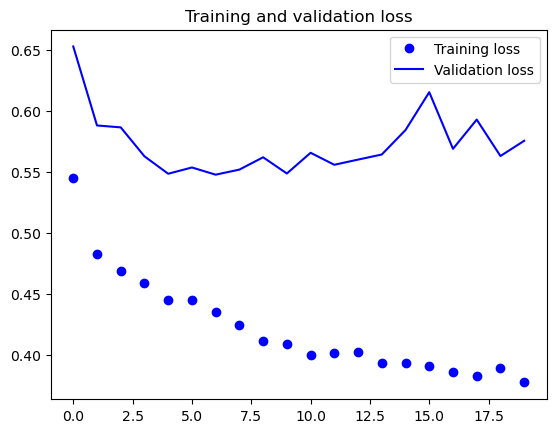

Test error: Number of Bicycle Hires    3778.993455
dtype: float64


In [15]:
# Train and evaluate a stacked GRU model using dropout regularization
model = Sequential()
model.add(layers.GRU(128,
                     dropout=0.2,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, scaled_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.2,
                     recurrent_dropout=0.5))
model.add(layers.Dense(data_to_pred.shape[-1]))
model.summary()

# Compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.002), loss='mae')
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# test the model
score = model.evaluate(x_test, y_test, verbose=0)
# denormalization the error, which shows the average error
# measured in Celsius degree.
print('Test error:', score * std)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, None, 128)         74240     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 123,713
Trainable params: 123,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
26/26 [==============================] - 12s 222ms/step - loss: 0.6143 - val_loss: 0.6176
Epoch 2/20
26/26 [==============================] - 5s 194ms/step - loss: 0.4940 - val_loss: 0.6963
Epoch 3/20
26/26 [==============================] - 5s 199ms/step - loss: 0.4845 - val_loss: 0.6314
Epoch 4/20


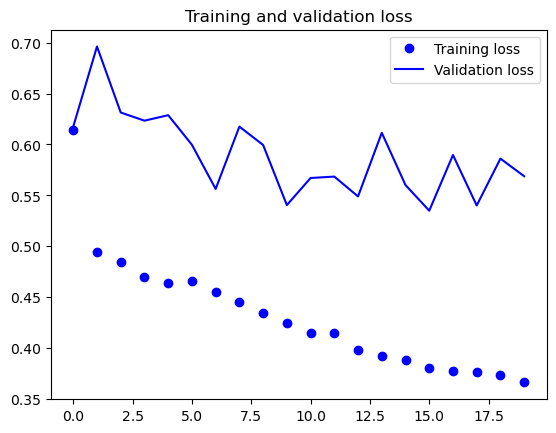

Test error: Number of Bicycle Hires    3749.913451
dtype: float64


In [21]:
# Train and evaluate a stacked LSTM model using dropout regularization
model = Sequential()
model.add(layers.LSTM(128,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      return_sequences=True,
                      input_shape=(None, scaled_data.shape[-1])))
model.add(layers.LSTM(64,
                      activation='relu',
                      dropout=0.1,
                      recurrent_dropout=0.5))
model.add(layers.Dense(data_to_pred.shape[-1]))
model.summary()

# compile and train the model
model.compile(optimizer=RMSprop(learning_rate=0.0025),
              loss='mae')
history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_data=(x_val, y_val))

# paint the result
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# test the model
score = model.evaluate(x_test, y_test, verbose=0)
# denormalization the error, which shows the average error
# measured in Celsius degree.
print('Test error:', score * std)